In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import simps
from IPython.display import clear_output
import glob
import pybedtools as pbt

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.7)
    return True

## The objective here is to demonstrate that Expectation scores predict the G4 structures better than Quadparser and G4Hunter algorithms. For this two approaches will be used.

### First using G4-Seq data, all the genomic regions that either have OQs or do not have OQs (i.e. regions sequenced but did not showed only a marginal mismatch rate) were identified. Now using these regions TP, FN, FP, TN were identified using different Expectation value cutoffs.

In [3]:
def load_scores(scores_dir, chrom):
    chrom_info_file = '/home/parashar/scratch/hg19_resource/hg19.genome'
    chrom_info = [x.rstrip('\n').split('\t') for x in
                  open(chrom_info_file).readlines()]
    chrom_info = {x[0]: int(x[1]) for x in chrom_info}
    exp_s = np.zeros(chrom_info[chrom])
    for fn in glob.glob(scores_dir):
        exp = np.load(fn)
        if exp.shape[0] > 1:
            e_indices = np.array(exp[:, 0], dtype=int)
            e_scores = np.array(exp[:, 1], dtype=float)
            exp_s[e_indices] += e_scores
    return exp_s

def evaluate_positions(bed_file, strand, scores, data_points):
    positions = []
    h = open(bed_file)
    bed_data = h.readlines()
    h.close()
    for l in tqdm(bed_data, desc='Making positions'):
        c = l.rstrip('\n').split('\t')
        if c[3] == strand:
            start = int(c[1])
            stop = int(c[2])
            positions.extend(list(range(start, stop)))
    positions_scores = scores[positions]
    positions_scores = positions_scores[np.nonzero(positions_scores)[0]]
    
    pos_vals = []
    neg_vals = []
    for cutoff in tqdm(np.linspace(0, -5, data_points), desc='Evaluating positions'):
        pos_vals.append(len(np.where(positions_scores >= (2 ** cutoff))[0]))
        neg_vals.append(len(positions_scores) - pos_vals[-1])
    return pos_vals, neg_vals

true_p = []
false_p = []
true_neg = []
false_neg = []

chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']
data_points = 20
for chrom in chroms:
    for strand, opp_strand in zip(['+', '-'], ['negative', 'positive']):
        scores_dir = './data/quad_graph_single_base_scores/%s/%s/*_exp_score.npy' % (
            chrom, opp_strand)
        scores = load_scores(scores_dir, chrom)
        print (chrom, strand, flush=True)
        
        temp_val = evaluate_positions(
            "./data/ROC_data/regions/chrom_wise/Na_K_2_oq_regions_%s.bed" % chrom,
            strand, scores, data_points
        )
        true_p.append(temp_val[0])
        false_neg.append(temp_val[1])
        
        temp_val =  evaluate_positions(
            "./data/ROC_data/regions/chrom_wise/Na_K_2_no_oq_regions_%s.bed" % chrom,
            strand, scores, data_points
        )
        false_p.append(temp_val[0])
        true_neg.append(temp_val[1])l
        clear_output()
        
true_p = np.array(true_p)
false_neg = np.array(false_neg)
false_p = np.array(false_p)
true_neg = np.array(true_neg)

np.save('./data/ROC_data/K2_TP', true_p)
np.save('./data/ROC_data/K2_FN', false_neg)
np.save('./data/ROC_data/K2_FP', false_p)
np.save('./data/ROC_data/K2_TN', true_neg)

### Similarly TP, FN, FP and TN were identified for the Quadparser

In [95]:
def evaluate_motif_positions(region_bed_file, g4_bed_file):
    fixed_g4_bed = []
    with open(g4_bed_file) as h:
        for l in h:
            c = l.split('\t')
            strand = "+" if c[4][0] == "G" else "C"
            fixed_g4_bed.append("\t".join([
                c[0], c[1], c[2], '.', '0', strand
            ]))
    g4_bed = pbt.BedTool("\n".join(fixed_g4_bed), from_string=True)

    fixed_region_bed = []
    with open(region_bed_file) as h:
        for l in h:
            c = l.split('\t')
            fixed_region_bed.append("\t".join([
                c[0], c[1], c[2], '.', '0', c[3]
            ]))
    region_bed = pbt.BedTool("\n".join(fixed_region_bed), from_string=True)
    overlap = g4_bed.intersect(region_bed, S=True).count()
    return overlap, len(fixed_region_bed) - overlap

true_p_motif = []
false_p_motif = []
true_neg_motif = []
false_neg_motif = []

chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']

for chrom in chroms:
    chrom_wise_data = [[], [], [], []]
    for bulge in [0, 3]:
        for loop in [1, 3, 5, 7, 10, 15]:
            print (chrom, bulge, loop)
            temp_val = evaluate_motif_positions(
                "./data/ROC_data/regions/chrom_wise/Na_K_2_oq_regions_%s.bed" % chrom,
                "/home/parashar/scratch/quadruplexes/hg19/g3_%d_%d_%s_nov.bed" % (
                    loop, bulge, chrom)
            )
            chrom_wise_data[0].append(temp_val[0])
            chrom_wise_data[1].append(temp_val[1])
            
            temp_val = evaluate_motif_positions(
                "./data/ROC_data/regions/chrom_wise/Na_K_2_no_oq_regions_%s.bed" % chrom,
                "/home/parashar/scratch/quadruplexes/hg19/g3_%d_%d_%s_nov.bed" % (
                    loop, bulge, chrom)
            )
            chrom_wise_data[2].append(temp_val[0])
            chrom_wise_data[3].append(temp_val[1])
            
            clear_output()
    true_p_motif.append(chrom_wise_data[0])
    false_neg_motif.append(chrom_wise_data[1])
    false_p_motif.append(chrom_wise_data[2])
    true_neg_motif.append(chrom_wise_data[3])

true_p_motif = np.array(true_p_motif)
false_neg_motif = np.array(false_neg_motif)
false_p_motif = np.array(false_p_motif)
true_neg_motif = np.array(true_neg_motif)

np.save('./data/ROC_data/K2_TP_motif', true_p_motif)
np.save('./data/ROC_data/K2_FN_motif', false_neg_motif)
np.save('./data/ROC_data/K2_FP_motif', false_p_motif)
np.save('./data/ROC_data/K2_TN_motif', true_neg_motif)

### Similarly to identify TP, TN, FP, FN in G4Hunter following steps were taken:

#### First sequences of OQ and No-OQ regions were extracted and then G4Hunter script was run on them

In [94]:
def extract_seq(region_bed_file, fasta_file):
    bed = pbt.BedTool(region_bed_file)
    sequences = []
    data = open(bed.sequence(fi=fasta_file, s=True).seqfn).readlines()
    nuc_map = {'A': 'T', 'G': 'C', 'T': 'A', 'C': 'G', 'N': 'N'}
    for i in range(1, len(data), 2):
        seq = "".join([nuc_map[x] for x in data[i].rstrip('\n').upper()])
        sequences.append(seq)
    with open('data/ROC_data/seq_g4_hunter/%s.seq' % 
              region_bed_file.split('/')[-1].split('.')[0], 'w') as OUT:
        OUT.write("\n".join(sequences))

chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']

for chrom in chroms:
    extract_seq(
        "./data/ROC_data/regions/chrom_wise/Na_K_2_oq_regions_%s.bed" % chrom,
        "/home/parashar/scratch/hg19_resource/chromosomes/%s.fa" % chrom
    )
    extract_seq(
        "./data/ROC_data/regions/chrom_wise/Na_K_2_no_oq_regions_%s.bed" % chrom,
        "/home/parashar/scratch/hg19_resource/chromosomes/%s.fa" % chrom
    )

#### TP, FP, FN, TN values were calculated at various cutoffs for G4Hunter scores

In [124]:
def evaluate_hunter_scores(fn):
    scores = []
    with open(fn) as handle:
        next(handle)
        for l in handle:
            c = l.rstrip('\n').split('\t')
            scores.append(float(c[1]))
    scores = np.array(scores)
    pos = []
    neg = []
    for i in np.linspace(2, -2, 20):
        pos.append(len(np.where(scores >= i)[0]))
        neg.append(len(scores) - pos[-1])
    return pos, neg

true_p_hunter = []
false_neg_hunter = []
false_p_hunter = []
true_neg_hunter = []

chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']
base_dir = './data/ROC_data/scores_g4_hunter'
for chrom in tqdm(chroms):
    temp_val = evaluate_hunter_scores("%s/Na_K_2_oq_regions_%s" % (base_dir, chrom))
    true_p_hunter.append(temp_val[0])
    false_neg_hunter.append(temp_val[1])
    
    temp_val = evaluate_hunter_scores("%s/Na_K_2_no_oq_regions_%s" % (base_dir, chrom))
    false_p_hunter.append(temp_val[0])
    true_neg_hunter.append(temp_val[1])

clear_output()
true_p_hunter = np.array(true_p_hunter)
false_neg_hunter = np.array(false_neg_hunter)
false_p_hunter = np.array(false_p_hunter)
true_neg_hunter = np.array(true_neg_hunter)

np.save('./data/ROC_data/K2_TP_hunter', true_p_hunter)
np.save('./data/ROC_data/K2_FN_hunter', false_neg_hunter)
np.save('./data/ROC_data/K2_FP_hunter', false_p_hunter)
np.save('./data/ROC_data/K2_TN_hunter', true_neg_hunter)

### Now lets load all the TP, FP, FN, Tn values and make ROC and PR curves for the same

In [3]:
true_p_motif = np.load('./data/ROC_data/K2_TP_motif.npy')
false_neg_motif = np.load('./data/ROC_data/K2_FN_motif.npy')
false_p_motif = np.load('./data/ROC_data/K2_FP_motif.npy')
true_neg_motif = np.load('./data/ROC_data/K2_TN_motif.npy')

tpr_motif = true_p_motif.sum(axis=0) / (true_p_motif.sum(axis=0) +
                                        false_neg_motif.sum(axis=0))
fpr_motif  = false_p_motif.sum(axis=0) / (false_p_motif.sum(axis=0) +
                                          true_neg_motif.sum(axis=0))
precision_motif = true_p_motif.sum(axis=0) / (true_p_motif.sum(axis=0) +
                                              false_p_motif.sum(axis=0))
recall_motif= true_p_motif.sum(axis=0) / (true_p_motif.sum(axis=0) +
                                          false_neg_motif.sum(axis=0))

In [4]:
true_p_hunter = np.load('./data/ROC_data/K2_TP_hunter.npy')
false_neg_hunter = np.load('./data/ROC_data/K2_FN_hunter.npy')
false_p_hunter = np.load('./data/ROC_data/K2_FP_hunter.npy')
true_neg_hunter = np.load('./data/ROC_data/K2_TN_hunter.npy')

tpr_hunter = true_p_hunter.sum(axis=0) / (true_p_hunter.sum(axis=0) +
                                        false_neg_hunter.sum(axis=0))
fpr_hunter = false_p_hunter.sum(axis=0) / (false_p_hunter.sum(axis=0) +
                                          true_neg_hunter.sum(axis=0))
precision_hunter = true_p_hunter.sum(axis=0) / (true_p_hunter.sum(axis=0) +
                                              false_p_hunter.sum(axis=0))
recall_hunter = true_p_hunter.sum(axis=0) / (true_p_hunter.sum(axis=0) +
                                          false_neg_hunter.sum(axis=0))

In [5]:
true_p = np.load('./data/ROC_data/K2_TP.npy')
false_neg = np.load('./data/ROC_data/K2_FN.npy')
false_p = np.load('./data/ROC_data/K2_FP.npy')
true_neg = np.load('./data/ROC_data/K2_TN.npy')
tpr = true_p.sum(axis=0) / (true_p.sum(axis=0) + false_neg.sum(axis=0))
fpr = false_p.sum(axis=0) / (false_p.sum(axis=0) + true_neg.sum(axis=0))
precision = true_p.sum(axis=0) / (true_p.sum(axis=0) + false_p.sum(axis=0))
recall = true_p.sum(axis=0) / (true_p.sum(axis=0) + false_neg.sum(axis=0))

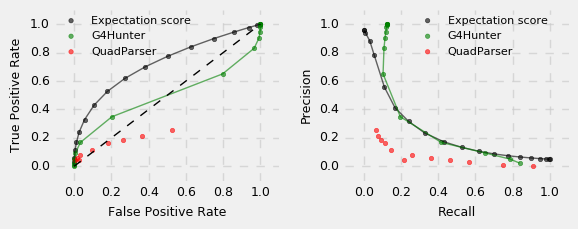

In [6]:
fig, axis = plt.subplots(1, 2, figsize=(6,2.5))

data_points = 20

ax = axis[0]
ax.plot(fpr, tpr, lw=1, color='k', alpha=0.6)
ax.scatter(fpr[3:], tpr[3:], s=10, color='k', marker='o', alpha=0.6, label='Expectation score')
ax.plot(fpr_hunter, tpr_hunter, lw=1, color='green', alpha=0.6)
ax.scatter(fpr_hunter[3:], tpr_hunter[3:], s=10, color='green', marker='o', alpha=0.6,
          label='G4Hunter')
ax.scatter(fpr_motif[3:], tpr_motif[3:], s=10, color='r', marker='o', alpha=0.6,
           label='QuadParser')
ax.plot([0,1], [0, 1], lw=1, ls='--', color='k')
clean_axis(ax)
ax.legend(frameon=False, loc=(0, 0.7), fontsize=8, scatterpoints=1)
ax.set_xlim((-0.1,1.1))
ax.set_ylim((-0.1,1.1))
ax.set_xlabel('False Positive Rate', fontsize=9)
ax.set_ylabel('True Positive Rate', fontsize=9)

ax = axis[1]
ax.plot(recall, precision, lw=1, color='k', alpha=0.6)
ax.scatter(recall, precision, s=10, color='k', marker='o', alpha=0.6,
           label='Expectation score')
ax.plot(precision_hunter[5:], recall_hunter[5:], lw=1, color='g', alpha=0.6)
ax.scatter(precision_hunter[5:], recall_hunter[5:], s=10, color='g', marker='o', alpha=0.6,
          label='G4Hunter')
ax.scatter(precision_motif, recall_motif, s=10, color='r', marker='o', alpha=0.6,
           label='QuadParser')
clean_axis(ax)
ax.legend(frameon=False, loc=(0.3, 0.7), fontsize=8, scatterpoints=1)
ax.set_xlim((-0.1,1.1))
ax.set_ylim((-0.1,1.1))
ax.set_xlabel('Recall', fontsize=9)
ax.set_ylabel('Precision', fontsize=9)

plt.tight_layout()
plt.savefig('roc_pr_K2.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('roc_pr_K2.svg', transparent=True, edgecolor='none')
plt.tight_layout()
plt.show()

In [178]:
auc = simps([tpr[x] for x in range(0, data_points, 2)],
            x=[fpr[x] for x in range(0, data_points, 2)])
auc_hunter = simps([tpr_hunter[x] for x in range(0,data_points,2)],
            x=[fpr_hunter[x] for x in range(0,data_points,2)])
auc_motif = simps(tpr_motif, fpr_motif)
auc, auc_hunter, auc_motif

(0.71137651717470374, 0.56383529744042959, 0.093793345521249738)